# **PACKAGES**

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import re
import datetime
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style

ROOT_DIR = os.getcwd()
if ROOT_DIR.endswith("notebooks"):
    ROOT_DIR = os.path.dirname(ROOT_DIR)

os.chdir(ROOT_DIR)

from src import utils, preprocessing
from src.models import XGB_Model, LGB_Model, CatBoost_Model, KNN_Model, KFold_Strategy, report_perf
import lightgbm as lgb
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")
import gc

# **DATA LOADING**

In [3]:
sanral = pd.read_csv("../data/output/train.csv")
submission = pd.read_csv("../data/SampleSubmission.csv")

In [4]:
target = pd.read_csv("../data/output/target.csv")
target.columns = ["target"]

In [5]:
sanral = pd.concat([utils.MultiColumnLabelEncoder().fit_transform(sanral[["segment_id", "name_day"]]), sanral.drop(["segment_id", "name_day"], axis=1)], axis=1)

In [6]:
sanral.head()

,segment_id,name_day,datetime,train_test,latitude,longitude,year,month,day,hour,roads_freq,days_freq,month_freq,day_freq,hour_freq
0,412,0,2016-01-01 00:00:00,1,-33.888275,18.540896,2016,1,1,0,0.003362,0.159658,0.081724,0.023941,0.049424
1,410,0,2016-01-01 00:00:00,1,-34.140857,18.930756,2016,1,1,0,0.001412,0.159658,0.081724,0.023941,0.049424
2,444,0,2016-01-01 00:00:00,1,-33.959154,18.553358,2016,1,1,0,0.003158,0.159658,0.081724,0.023941,0.049424
3,409,0,2016-01-01 00:00:00,1,-33.895258,18.677556,2016,1,1,0,0.000743,0.159658,0.081724,0.023941,0.049424
4,122,0,2016-01-01 00:00:00,1,-34.087051,18.837132,2016,1,1,0,0.017069,0.159658,0.081724,0.023941,0.049424


In [7]:
train, test = utils.separate_train_test(sanral)

In [8]:
train["target"] = target

In [9]:
train.head()

,segment_id,name_day,datetime,latitude,longitude,year,month,day,hour,roads_freq,days_freq,month_freq,day_freq,hour_freq,target
0,412,0,2016-01-01 00:00:00,-33.888275,18.540896,2016,1,1,0,0.003362,0.159658,0.081724,0.023941,0.049424,1.0
1,410,0,2016-01-01 00:00:00,-34.140857,18.930756,2016,1,1,0,0.001412,0.159658,0.081724,0.023941,0.049424,0.0
2,444,0,2016-01-01 00:00:00,-33.959154,18.553358,2016,1,1,0,0.003158,0.159658,0.081724,0.023941,0.049424,0.0
3,409,0,2016-01-01 00:00:00,-33.895258,18.677556,2016,1,1,0,0.000743,0.159658,0.081724,0.023941,0.049424,0.0
4,122,0,2016-01-01 00:00:00,-34.087051,18.837132,2016,1,1,0,0.017069,0.159658,0.081724,0.023941,0.049424,0.0


In [10]:
train.target.value_counts(True)

0.0    0.996408
1.0    0.003592
Name: target, dtype: float64

# **DOWNSAMPLING**

Let's consider a new sample of **60-40** of data in each category of my target.

In [11]:
n_samples = 0.6
n_negatives = int(np.round(1/n_samples * train[train.target==1].shape[0]))

In [12]:
n_negatives

85662

## **RANDOM SAMPLING**

In [13]:
random.seed(56)

negative_ids = list(train[train.target==0].index)
negative_ids = np.random.choice(negative_ids,n_negatives, replace=False)

In [14]:
new_train = train.loc[(train.target == 1) |
                      (train.index.isin(negative_ids))]

new_train = new_train.sort_index(ascending=True)

In [15]:
new_train.tail()

,segment_id,name_day,datetime,latitude,longitude,year,month,day,hour,roads_freq,days_freq,month_freq,day_freq,hour_freq,target
14308987,57,1,2018-12-31 23:00:00,-33.849859,18.708148,2018,12,31,23,0.000241,0.160364,0.093425,0.017961,0.014896,1.0
14309194,170,1,2018-12-31 23:00:00,-33.831272,18.751022,2018,12,31,23,0.000279,0.160364,0.093425,0.017961,0.014896,0.0
14309208,390,1,2018-12-31 23:00:00,-33.921624,18.478168,2018,12,31,23,0.001579,0.160364,0.093425,0.017961,0.014896,0.0
14309254,312,1,2018-12-31 23:00:00,-33.960305,18.461827,2018,12,31,23,0.000019,0.160364,0.093425,0.017961,0.014896,0.0
14309295,9,1,2018-12-31 23:00:00,-34.062133,18.800114,2018,12,31,23,0.000056,0.160364,0.093425,0.017961,0.014896,0.0


# **MODELIZATION**

In [16]:
target = new_train.target
new_train.drop("target", axis=1, inplace=True)

In [17]:
X = new_train.drop(["datetime"], axis=1)
X_test = test.drop(["datetime"], axis=1)

### **XGBOOST**

In [113]:
dtrain = XGB_Model().prepare_data(X, target)
dtest = XGB_Model().prepare_data(X_test.iloc[544:,:], None)

In [118]:
xgb_params = {
    'max_depth': 4, 
    'eta': 0.1, 
    'objective': 'binary:logistic',
    'nthread'  : 4,
    #'eval_metric' : "error",
}

In [129]:
cv_classif_xgb = XGB_Model().train_xgb_cv(dtrain, params=xgb_params, nfold=5, num_boost_round=1000)

In [130]:
cv_classif_xgb

,train-error-mean,train-error-std,train-f1_err-mean,train-f1_err-std,test-error-mean,test-error-std,test-f1_err-mean,test-f1_err-std
0,0.316444,0.000954,0.384167,0.000829,0.316747,0.003316,0.384523,0.004317
1,0.316358,0.001056,0.384657,0.001221,0.316426,0.003726,0.384726,0.003260
2,0.314076,0.000718,0.383031,0.002075,0.314295,0.003846,0.383378,0.005453
3,0.309500,0.000966,0.388618,0.004669,0.309896,0.005205,0.388831,0.003153
4,0.308719,0.001615,0.388523,0.005806,0.309414,0.004301,0.389069,0.003301
...,...,...,...,...,...,...,...,...
995,0.173923,0.000570,0.236768,0.001031,0.189809,0.002447,0.258801,0.002843
996,0.173870,0.000573,0.236691,0.001038,0.189787,0.002387,0.258774,0.002753
997,0.173825,0.000584,0.236631,0.001076,0.189809,0.002384,0.258802,0.002763
998,0.173830,0.000572,0.236646,0.001053,0.189824,0.002415,0.258817,0.002835


In [93]:
print("Argmin is:", np.argmin(cv_classif_xgb['test-error-mean']), "and the minimum is :", np.min(cv_classif_xgb['test-error-mean']))

Argmin is: 908 and the minimum is : 0.1895388


In [95]:
xgb_num_boost = np.argmin(cv_classif_xgb['test-error-mean'])

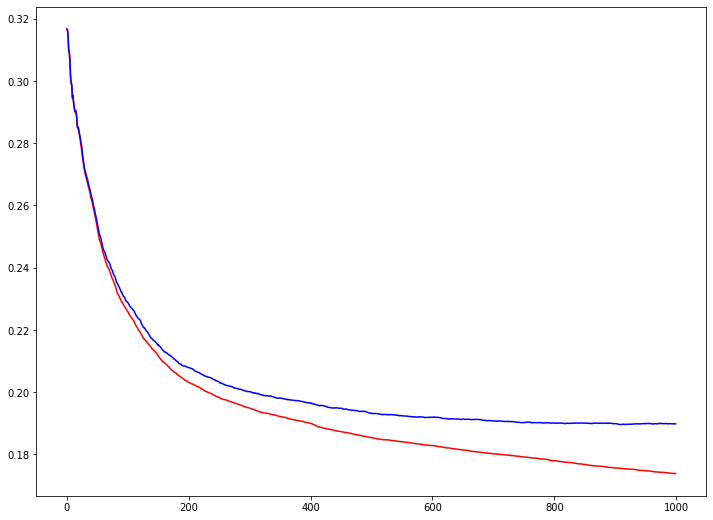

In [98]:
plt.figure(figsize=(12,9))

plt.plot(cv_classif_xgb['train-error-mean'], color="red")
#plt.plot(cv_rmse_xgb['train-rmse-mean'] + cv_rmse_xgb['train-rmse-std'], color="red", marker="+")
#plt.plot(cv_rmse_xgb['train-rmse-mean'] - cv_rmse_xgb['train-rmse-std'], color="red", marker="+")
plt.plot(cv_classif_xgb['test-error-mean'], color="blue")
#plt.plot(cv_rmse_xgb['test-rmse-mean'] + cv_rmse_xgb['test-rmse-std'], color="blue", marker="+")
#plt.plot(cv_rmse_xgb['test-rmse-mean'] - cv_rmse_xgb['test-rmse-std'], color="blue", marker="+")

In [99]:
xgb_model = XGB_Model().train_xgb(dtrain,  xgb_params, xgb_num_boost)

In [114]:
xgb_pred = xgb_model.predict(dtest)
xgb_pred_train = xgb_model.predict(dtrain)

In [127]:
xgb_submission = submission
xgb_submission["prediction"] = np.round(xgb_pred)

In [128]:
xgb_submission.to_csv("../submissions/XgBoost_simple_Le.csv", index=False)

#### **TEST FOR XGBOOST**

In [146]:
class_weights = np.ones(new_train.shape[0])
class_weights[target==1] = 99
class_weights[target==0] = 1

In [152]:
xgb_classifier = xgb.XGBClassifier(
    max_depth=4,
    n_estimators=900,
    n_jobs=-1)

In [ ]:
xgb_classifier.fit(X, target, sample_weight=class_weights)

[19:26:40] WARNING: src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


In [ ]:
xgb_pred = xgb_classifier.predict(X_test.iloc[544:,:])

### **LGBM**

In [18]:
dtrain = LGB_Model().prepare_data(X, target)
dtest = LGB_Model().prepare_data(X_test, None)

In [24]:
lgb_params = {
    'boosting': "gbdt", 
    'learning_rate': 0.1, 
    'objective': 'binary',
    'num_threads'  : 4,
#    'metric' : "binary",
}

In [44]:
cv_classif_lgb = LGB_Model().train_lgb_cv(dtrain, params=lgb_params, nfold=5, num_boost_round=1000)

In [45]:
cv_classif_lgb = pd.DataFrame(cv_classif_lgb)
cv_classif_lgb

,binary_logloss-mean,binary_logloss-stdv,f1_err-mean,f1_err-stdv
0,0.642188,0.002133,0.000000,0.000000
1,0.626463,0.001836,0.000000,0.000000
2,0.612966,0.001912,0.145653,0.028896
3,0.601233,0.001712,0.207679,0.022838
4,0.591315,0.001498,0.318899,0.033667
...,...,...,...,...
995,0.401449,0.003639,0.743581,0.002683
996,0.401450,0.003650,0.743542,0.002668
997,0.401448,0.003651,0.743564,0.002652
998,0.401459,0.003645,0.743564,0.002713


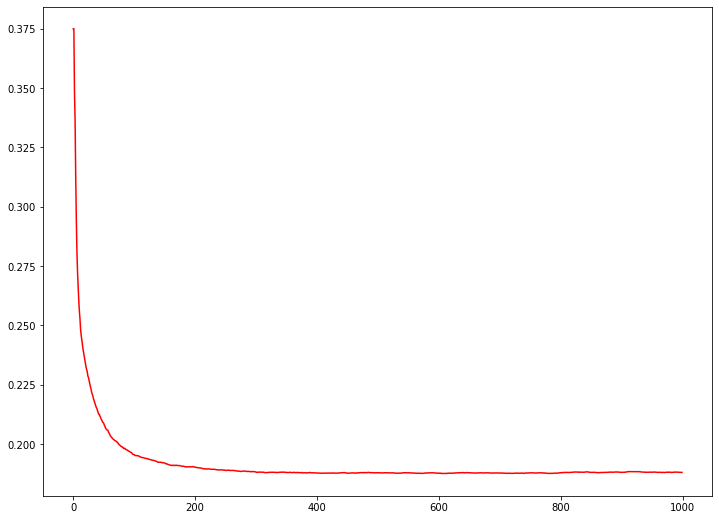

In [31]:
plt.figure(figsize=(12,9))

plt.plot(cv_classif_lgb['binary_error-mean'], color="red")

In [32]:
print("Argmin is:", np.argmin(cv_classif_lgb['binary_error-mean']), "and the minimum is :", np.min(cv_classif_lgb['binary_error-mean']))

Argmin is: 607 and the minimum is : 0.1875451461092262


In [34]:
lgb_num_boost = np.argmin(cv_classif_lgb['binary_error-mean'])

In [35]:
lgb_model = LGB_Model().train_lgb(dtrain,  lgb_params, lgb_num_boost)

In [38]:
lgb_pred = lgb_model.predict(X_test.iloc[544:,:])
lgb_pred_train = lgb_model.predict(X)

In [39]:
lgb_submission = submission
lgb_submission["prediction"] = np.round(lgb_pred)

In [40]:
lgb_submission.to_csv("../submissions/LgBM_simple_Le.csv", index=False)